In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle # To save the model
import re # For regular expressions in text cleaning

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Loading the dataset
data1=pd.read_csv("DataAnalyst.csv")


In [4]:
data1.head(5)

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


In [6]:
data1.shape

(2253, 16)

In [7]:
data1.info

<bound method DataFrame.info of       Unnamed: 0                                          Job Title  \
0              0  Data Analyst, Center on Immigration and Justic...   
1              1                               Quality Data Analyst   
2              2  Senior Data Analyst, Insights & Analytics Team...   
3              3                                       Data Analyst   
4              4                             Reporting Data Analyst   
...          ...                                                ...   
2248        2248  RQS - IHHA - 201900004460 -1q Data Security An...   
2249        2249              Senior Data Analyst (Corporate Audit)   
2250        2250  Technical Business Analyst (SQL, Data analytic...   
2251        2251                Data Analyst 3, Customer Experience   
2252        2252                        Senior Quality Data Analyst   

                  Salary Estimate  \
0      $37K-$66K (Glassdoor est.)   
1      $37K-$66K (Glassdoor est.)   
2   

In [8]:
data1.columns.tolist()

['Unnamed: 0',
 'Job Title',
 'Salary Estimate',
 'Job Description',
 'Rating',
 'Company Name',
 'Location',
 'Headquarters',
 'Size',
 'Founded',
 'Type of ownership',
 'Industry',
 'Sector',
 'Revenue',
 'Competitors',
 'Easy Apply']

In [12]:
# Cleaning the dataset

# Droping the 'Unnamed: 0' column if it exists, as it's typically an index column
if 'Unnamed: 0' in data1.columns:
    data1 = data1.drop('Unnamed: 0', axis=1)
    print("Dropped 'Unnamed: 0' column.")


Dropped 'Unnamed: 0' column.


In [13]:
# Handle missing values and inconsistent entries

# Replace '-1' and 'Unknown' with NaN across relevant columns
data1 = data1.replace(['-1', '-1.0', 'Unknown', 'unknown', '-'], np.nan)
print("Replaced '-1', '-1.0', 'Unknown', '-' with NaN.")


Replaced '-1', '-1.0', 'Unknown', '-' with NaN.


In [15]:
# Droping rows where 'Salary Estimate' is NaN, as salary is crucial for prediction

initial_rows = data1.shape[0]
data1.dropna(subset=['Salary Estimate'], inplace=True)
print(f"Dropped {initial_rows - data1.shape[0]} rows with missing 'Salary Estimate'.")



Dropped 1 rows with missing 'Salary Estimate'.


In [18]:
# Parse 'Salary Estimate' to create 'min_salary', 'max_salary', and 'Avg_Salary(K)'
# Example: "$37K-$66K (Glassdoor est.)"

def parse_salary(salary_str):
    try:
        # Remove text like '(Glassdoor est.)'
        salary_str = salary_str.split('(')[0].strip()
        # Remove '$' and 'K'
        salary_str = salary_str.replace('$', '').replace('K', '')

        # Split into min and max
        if '-' in salary_str:
            min_s, max_s = map(int, salary_str.split('-'))
        elif 'Per Hour' in salary_str:
            # Handle hourly rates (e.g., '$18-$25 Per Hour') by assuming 2080 working hours per year
            salary_str = salary_str.replace('Per Hour', '').strip()
            min_s, max_s = map(int, salary_str.split('-'))
            min_s = min_s * 2080 / 1000 # Convert to K$
            max_s = max_s * 2080 / 1000 # Convert to K$
        else:
            # If it's a single value, treat it as both min and max
            min_s = max_s = int(salary_str)

        return pd.Series([min_s, max_s, (min_s + max_s) / 2])
    except:
        return pd.Series([np.nan, np.nan, np.nan]) # Return NaN for unparseable entries

data1[['min_salary', 'max_salary', 'Avg_Salary(K)']] = data1['Salary Estimate'].apply(parse_salary)

# Droping rows where salary parsing failed

initial_rows_after_salary_parse = data1.shape[0]
data1.dropna(subset=['Avg_Salary(K)'], inplace=True)
print(f"Dropped {initial_rows_after_salary_parse - data1.shape[0]} rows where salary parsing failed.")



Dropped 0 rows where salary parsing failed.


In [19]:
# Clean 'Rating' column: Convert to numeric and fill NaN with median

data1['Rating'] = pd.to_numeric(data1['Rating'], errors='coerce') # Coerce non-numeric to NaN
data1['Rating'].fillna(data1['Rating'].median(), inplace=True)
print("Cleaned 'Rating' column: converted to numeric and filled NaNs with median.")

# Clean 'Company Name': remove numerical ratings if present (e.g., 'Company 3.5')

data1['Company Name'] = data1['Company Name'].astype(str).apply(lambda x: re.sub(r'\d+\.?\d*$', '', x).strip())
print("Cleaned 'Company Name' by removing numerical ratings.")


Cleaned 'Rating' column: converted to numeric and filled NaNs with median.
Cleaned 'Company Name' by removing numerical ratings.


In [25]:
# Fill other categorical missing values with 'Not Specified' or mode as appropriate

for col in ['Type of ownership', 'Industry', 'Sector', 'Revenue', 'Size', 'Job Title', 'Location']:
    if col in data1.columns: # Check if column exists before trying to fill
        data1[col].fillna('Not Specified', inplace=True)
        print(f"Filled NaNs in '{col}' with 'Not Specified'.")


Filled NaNs in 'Type of ownership' with 'Not Specified'.
Filled NaNs in 'Industry' with 'Not Specified'.
Filled NaNs in 'Sector' with 'Not Specified'.
Filled NaNs in 'Revenue' with 'Not Specified'.
Filled NaNs in 'Size' with 'Not Specified'.
Filled NaNs in 'Job Title' with 'Not Specified'.
Filled NaNs in 'Location' with 'Not Specified'.


In [23]:
# For numerical features like 'Founded', fill with a logical placeholder or median if necessary
# Assuming 'Founded' will be used for 'age' feature later

if 'Founded' in data1.columns:
    data1['Founded'] = pd.to_numeric(data1['Founded'], errors='coerce')
    data1['Founded'].fillna(data1['Founded'].median(), inplace=True) # Fill with median year
    print("Cleaned 'Founded' column: converted to numeric and filled NaNs with median.")


print("\nData after cleaning (info()):")
data1.info()


Cleaned 'Founded' column: converted to numeric and filled NaNs with median.

Data after cleaning (info()):
<class 'pandas.core.frame.DataFrame'>
Index: 2252 entries, 0 to 2252
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          2252 non-null   object 
 1   Salary Estimate    2252 non-null   object 
 2   Job Description    2252 non-null   object 
 3   Rating             2252 non-null   float64
 4   Company Name       2252 non-null   object 
 5   Location           2252 non-null   object 
 6   Headquarters       2080 non-null   object 
 7   Size               2047 non-null   object 
 8   Founded            2252 non-null   int64  
 9   Type of ownership  2252 non-null   object 
 10  Industry           2252 non-null   object 
 11  Sector             2252 non-null   object 
 12  Revenue            2252 non-null   object 
 13  Competitors        521 non-null    object 
 14  Easy Apply        


---  Performing Exploratory Data Analysis ---

Descriptive statistics for numerical columns:
            Rating      Founded   min_salary   max_salary  Avg_Salary(K)
count  2252.000000  2252.000000  2252.000000  2252.000000    2252.000000
mean      3.160080  1398.255329    54.266874    89.979130      72.123002
std       1.665393   902.040151    19.575375    29.315605      23.600734
min      -1.000000    -1.000000    24.000000    38.000000      33.500000
25%       3.100000    -1.000000    41.000000    70.000000      58.000000
50%       3.600000  1979.000000    50.000000    87.000000      69.000000
75%       4.000000  2002.000000    64.000000   104.000000      80.500000
max       5.000000  2019.000000   113.000000   190.000000     150.000000

Distribution of Salary_Average:


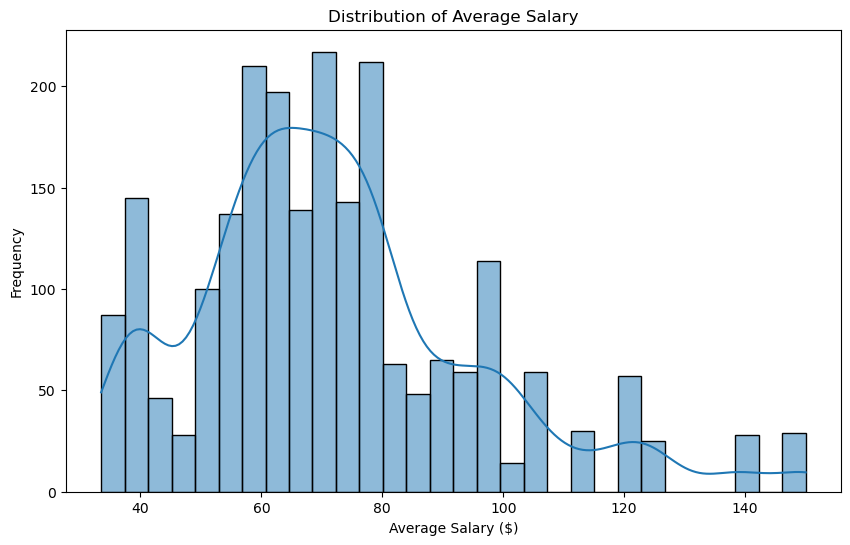


Top 10 Job Titles:
Job Title
Data Analyst               405
Senior Data Analyst         90
Junior Data Analyst         30
Business Data Analyst       28
Sr. Data Analyst            21
Data Quality Analyst        17
Data Analyst Junior         17
Data Analyst II             17
Data Governance Analyst     16
Lead Data Analyst           15
Name: count, dtype: int64

Top 10 Industries:
Industry
Not Specified                              353
IT Services                                325
Staffing & Outsourcing                     322
Health Care Services & Hospitals           151
Computer Hardware & Software               111
Consulting                                 111
Investment Banking & Asset Management       78
Enterprise Software & Network Solutions     69
Internet                                    65
Advertising & Marketing                     51
Name: count, dtype: int64

Top 10 Locations:
Location
New York, NY         310
Chicago, IL          130
San Francisco, CA    119
Austin

In [41]:
#  Performing Exploratory Data Analysis (EDA) 
print("\n---  Performing Exploratory Data Analysis ---")

print("\nDescriptive statistics for numerical columns:")
print(data1.describe())

print("\nDistribution of Salary_Average:")
plt.figure(figsize=(10, 6))
sns.histplot(data1['Avg_Salary(K)'], bins=30, kde=True)
plt.title('Distribution of Average Salary')
plt.xlabel('Average Salary ($)')
plt.ylabel('Frequency')
plt.show()

print("\nTop 10 Job Titles:")
print(data1['Job Title'].value_counts().head(10))

print("\nTop 10 Industries:")
print(data1['Industry'].value_counts().head(10))

print("\nTop 10 Locations:")
print(data1['Location'].value_counts().head(10))

print("\nDistribution of Company Size:")
print(data1['Size'].value_counts())



---  Generating Data Visualizations ---


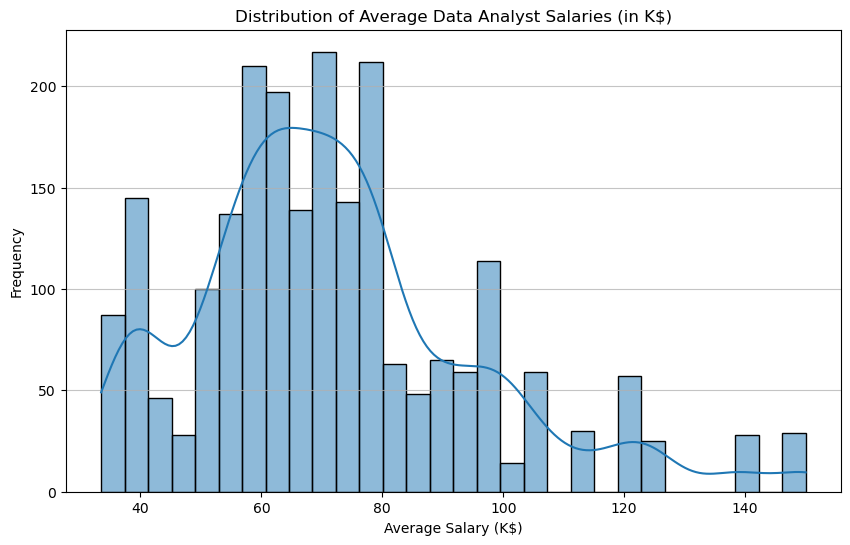

Generated: Salary Distribution plot.


In [35]:
#  Using visualization to explore data 
print("\n---  Generating Data Visualizations ---")

#  Salary Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data1['Avg_Salary(K)'], kde=True, bins=30)
plt.title('Distribution of Average Data Analyst Salaries (in K$)')
plt.xlabel('Average Salary (K$)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
print("Generated: Salary Distribution plot.")

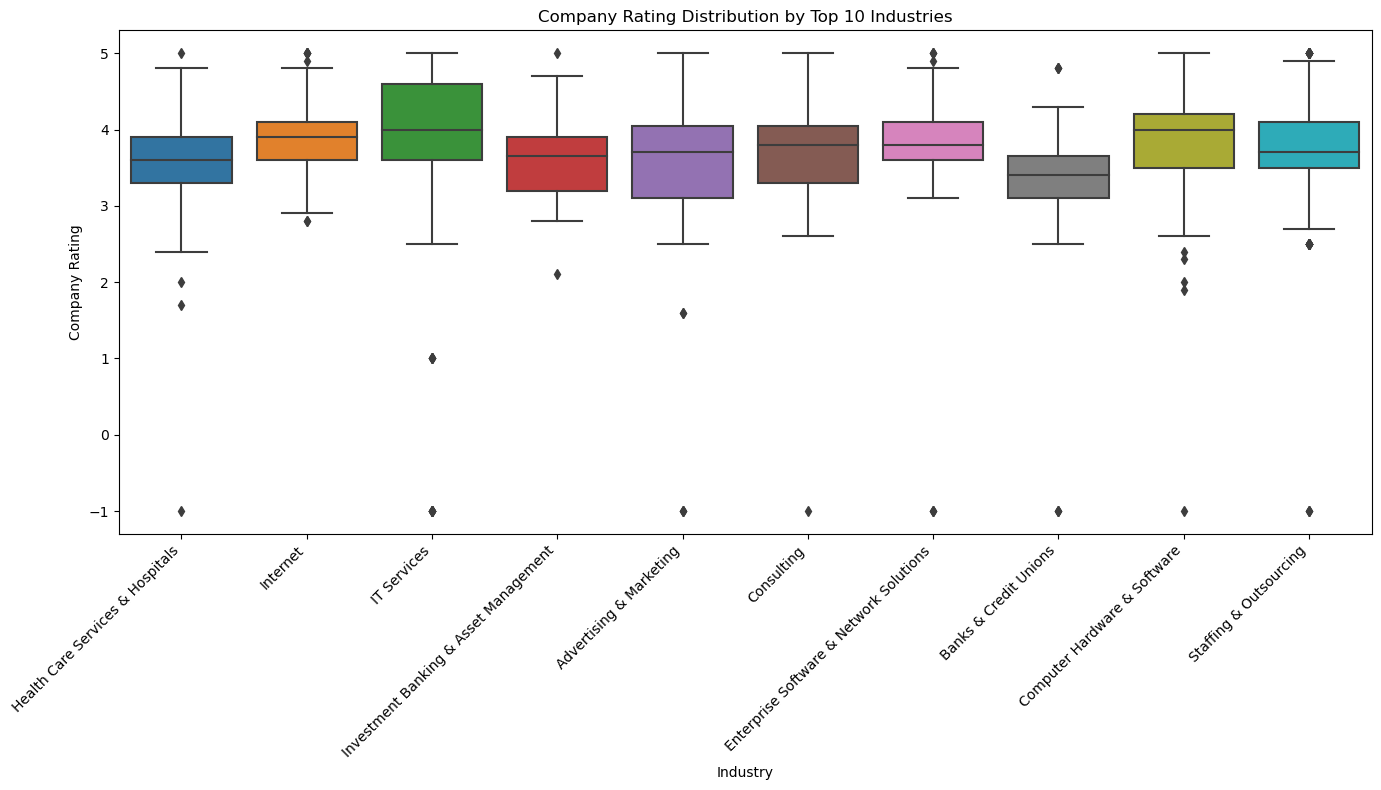

Generated: Rating by Industry plot (Top 10).


In [34]:
#  Rating by Industry (Top 10 Industries)

# First, identify top 10 industries (excluding 'Not Specified')
top_industries = data1[data1['Industry'] != 'Not Specified']['Industry'].value_counts().head(10).index

plt.figure(figsize=(14, 8))
sns.boxplot(x='Industry', y='Rating', data=data1[data1['Industry'].isin(top_industries)])
plt.title('Company Rating Distribution by Top 10 Industries')
plt.xlabel('Industry')
plt.ylabel('Company Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("Generated: Rating by Industry plot (Top 10).")


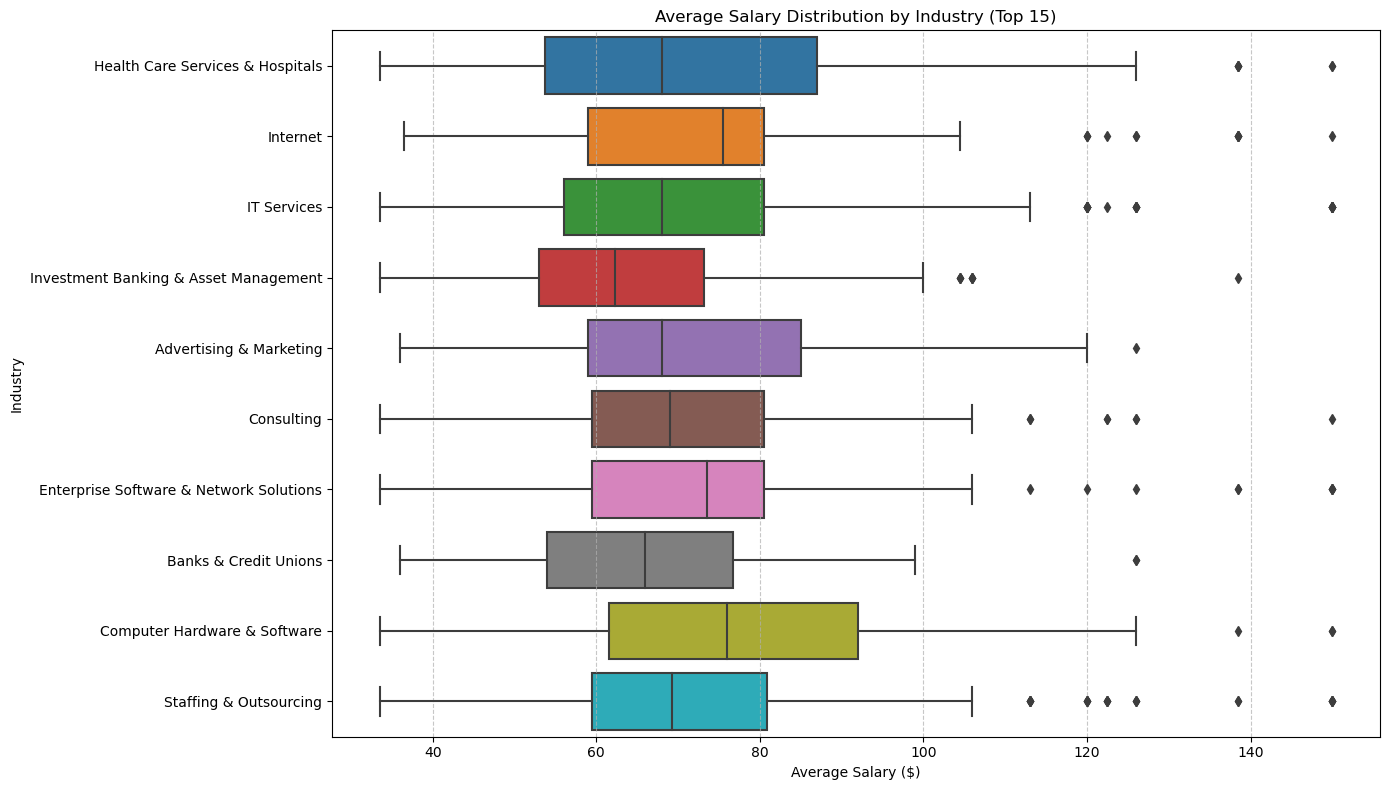

In [39]:
# Visualization 2: Salary Distribution by Industry (Top 15 Industries)
plt.figure(figsize=(14, 8))
sns.boxplot(x='Avg_Salary(K)', y='Industry', data=data1[data1['Industry'].isin(top_industries)])
plt.title('Average Salary Distribution by Industry (Top 15)')
plt.xlabel('Average Salary ($)')
plt.ylabel('Industry')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


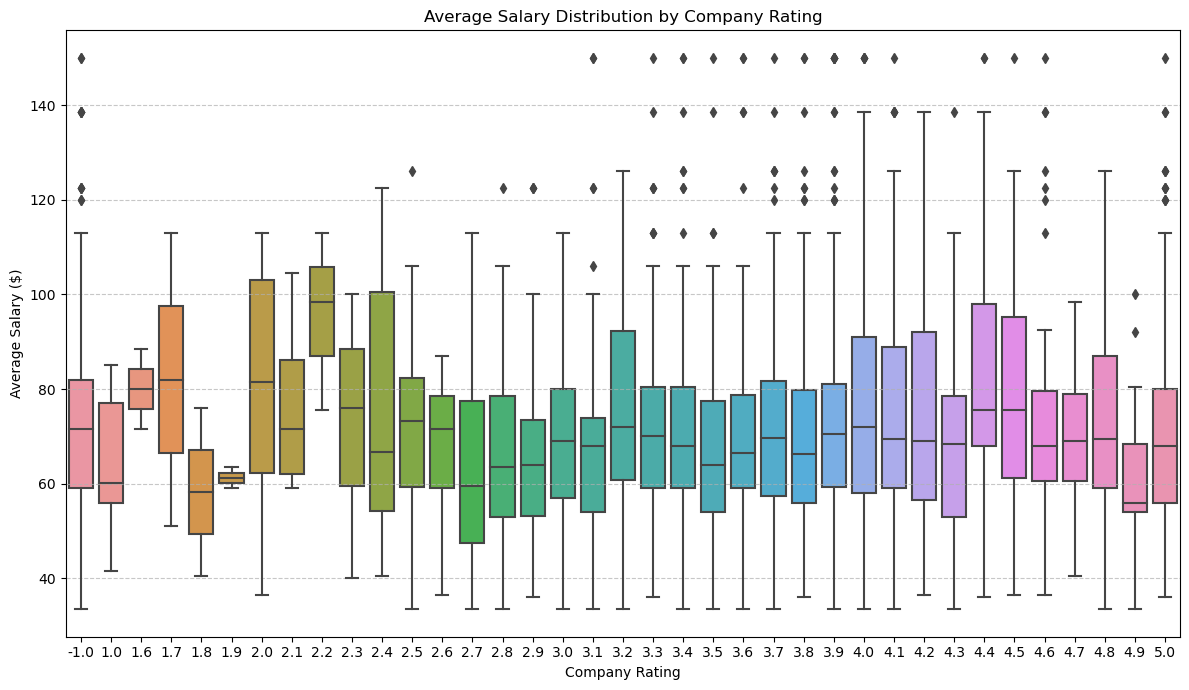

In [43]:
# Visualization 3: Salary Distribution by Rating

plt.figure(figsize=(12, 7))
sns.boxplot(x='Rating', y='Avg_Salary(K)', data=data1)
plt.title('Average Salary Distribution by Company Rating')
plt.xlabel('Company Rating')
plt.ylabel('Average Salary ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

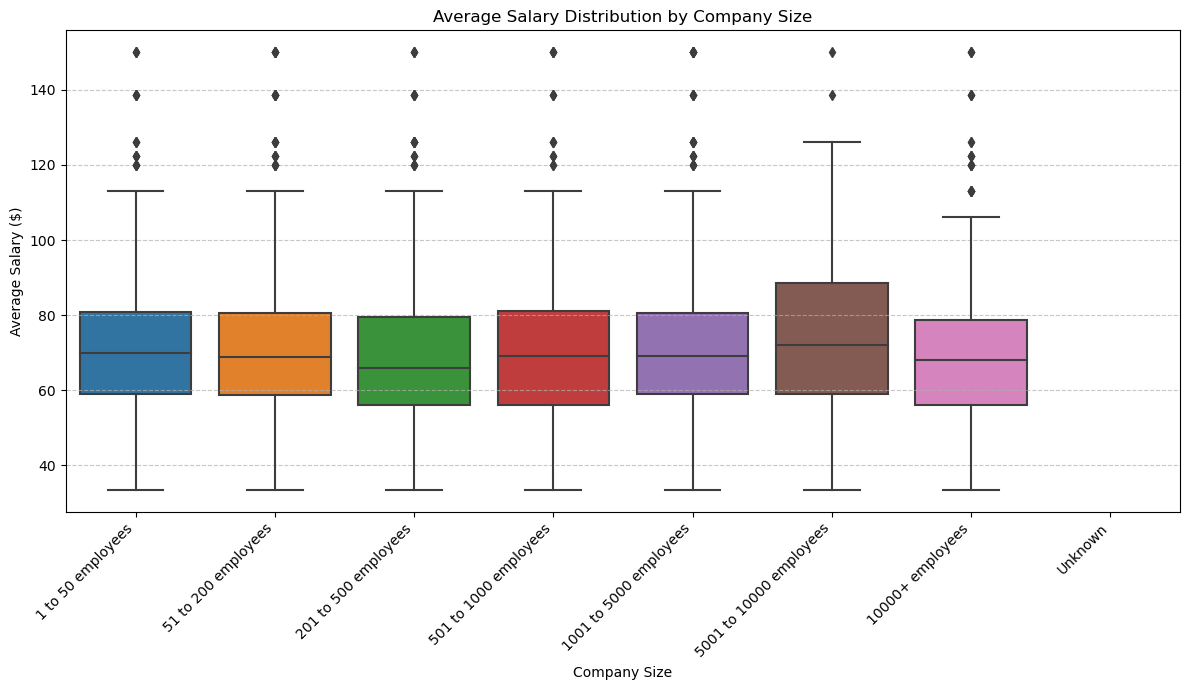

In [44]:
# Visualization 4: Salary Distribution by Company Size
plt.figure(figsize=(12, 7))
order_size = ['1 to 50 employees', '51 to 200 employees', '201 to 500 employees',
              '501 to 1000 employees', '1001 to 5000 employees', '5001 to 10000 employees',
              '10000+ employees', 'Unknown'] # Order for better visualization
sns.boxplot(x='Size', y='Avg_Salary(K)', data=data1, order=order_size)
plt.title('Average Salary Distribution by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Average Salary ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [47]:
# --- Step 5: Standardising the data ---
print("\n Standardizing the data ")

# Identify numerical columns for standardization (excluding the target 'Salary_Average' and one-hot encoded ones later)
numerical_cols = ['Rating', 'Founded']

# Check if 'Salary_Average' is already in a reasonable range or needs scaling for specific models later.
# For now, we'll scale 'Rating' and 'Founded' (if we decide to use it directly in models)

scaler = StandardScaler()
# Create a copy to avoid modifying the original DataFrame directly before all steps
data1_scaled = data1.copy()

# Scale numerical features (excluding target variable)
for col in numerical_cols:
    data1_scaled[col + '_scaled'] = scaler.fit_transform(data1_scaled[[col]])
    print(f"Column '{col}' scaled to '{col}_scaled'.")

print("\nFirst 5 rows with scaled columns:")
print(data1_scaled[['Rating', 'Rating_scaled', 'Founded', 'Founded_scaled']].head())



 Standardizing the data 
Column 'Rating' scaled to 'Rating_scaled'.
Column 'Founded' scaled to 'Founded_scaled'.

First 5 rows with scaled columns:
   Rating  Rating_scaled  Founded  Founded_scaled
0     3.2       0.023976     1961        0.623996
1     3.8       0.384331     1893        0.548595
2     3.4       0.144094     2003        0.670568
3     4.1       0.564509     2002        0.669459
4     3.9       0.444390     2009        0.677221


In [ ]:
# --- Step 6: Feature engineering ---
print("--- Feature Engineering ---")

# Text Analysis (Example: Extracting keywords from Job Title)
# Let's simplify by extracting common job levels/roles from 'Job Title'

def extract_job_level(title):
    title = title.lower()
    if 'senior' in title or 'sr.' in title:
        return 'Senior'
    elif 'lead' in title:
        return 'Lead'
    elif 'junior' in title or 'jr.' in title:
        return 'Junior'
    elif 'manager' in title:
        return 'Manager'
    elif 'director' in title:
        return 'Director'
    else:
        return 'Associate/Mid-level'

data1_scaled['Job_Level'] = data1_scaled['Job Title'].apply(extract_job_level)
print("\nCreated 'Job_Level' feature from 'Job Title'.")
print(data1_scaled['Job_Level'].value_counts())

# Extracting skills from Job Description 
# For this project, we'll focus on simpler keyword extraction.

keywords = ['python', 'r', 'sql', 'excel', 'tableau', 'power bi', 'aws', 'azure', 'gcp',
            'spark', 'hadoop', 'machine learning', 'ml', 'deep learning', 'dl',
            'statistics', 'sas', 'ssis', 'etl', 'dashboard', 'visualization',
            'big data', 'nosql', 'mongodb', 'kafka', 'airflow']

for keyword in keywords:
    data1_scaled[f'skill_{keyword.replace(" ", "_")}'] = data1_scaled['Job Description'].apply(lambda x: 1 if keyword in x.lower() else 0)
    # print(f"Created skill feature for: {keyword}")

print(f"\nExtracted {len(keywords)} skill features from 'Job Description'. Example columns:")
print(data1_scaled[[col for col in data1_scaled.columns if 'skill_' in col]].head())


--- Feature Engineering ---

Created 'Job_Level' feature from 'Job Title'.
Job_Level
Associate/Mid-level    1721
Senior                  378
Junior                   69
Lead                     58
Manager                  25
Director                  1
Name: count, dtype: int64

Extracted 26 skill features from 'Job Description'. Example columns:
   skill_python  skill_r  skill_sql  skill_excel  skill_tableau  \
0             1        1          1            0              0   
1             0        1          1            1              0   
2             1        1          1            1              1   
3             0        1          1            0              1   
4             1        1          1            1              0   

   skill_power_bi  skill_aws  skill_azure  skill_gcp  skill_spark  ...  \
0               0          1            0          0            0  ...   
1               0          0            0          0            0  ...   
2               0         

In [51]:
#  Location splits
# Extract 'State' from 'Location'

data1_scaled['State'] = data1_scaled['Location'].apply(lambda x: x.split(',')[1].strip() if ',' in x else 'Unknown')
# Handle 'United States' or 'USA' states if they are lumped together
data1_scaled['State'] = data1_scaled['State'].replace({'United States': 'USA', 'USA': 'USA'}) # Example cleaning

print("\nCreated 'State' feature from 'Location'. Top 5 states:")
print(data1_scaled['State'].value_counts().head())

# Age of Company
data1_scaled['Company_Age'] = 2025 - data1_scaled['Founded']
data1_scaled['Company_Age'] = data1_scaled['Company_Age'].apply(lambda x: x if x >= 0 else 0) # Handle potential future dates or -1
print("\nCreated 'Company_Age' feature.")

# One-hot encoding for categorical features for model training
# Select relevant categorical columns for one-hot encoding
categorical_cols = ['Size', 'Type of ownership', 'Industry', 'Sector', 'Revenue',
                    'Job_Level', 'State'] # Removed 'Competitors' as it's too high cardinality

# Filter out categories with too many unique values or 'Unknown' if not desired
# For 'Industry', 'Sector', 'State', we can limit to top N categories to avoid too many features
top_n_industries = data1_scaled['Industry'].value_counts().head(20).index
top_n_sectors = data1_scaled['Sector'].value_counts().head(15).index
top_n_states = data1_scaled['State'].value_counts().head(15).index

data1_scaled['Industry_Cleaned'] = data1_scaled['Industry'].apply(lambda x: x if x in top_n_industries else 'Other_Industry')
data1_scaled['Sector_Cleaned'] = data1_scaled['Sector'].apply(lambda x: x if x in top_n_sectors else 'Other_Sector')
data1_scaled['State_Cleaned'] = data1_scaled['State'].apply(lambda x: x if x in top_n_states else 'Other_State')

# Update categorical columns list for encoding
categorical_cols_to_encode = ['Size', 'Type of ownership', 'Industry_Cleaned', 'Sector_Cleaned', 'Revenue',
                              'Job_Level', 'State_Cleaned']

data1_encoded = pd.get_dummies(data1_scaled, columns=categorical_cols_to_encode, drop_first=True)
print("\nPerformed One-Hot Encoding for selected categorical features.")
print(f"Shape after one-hot encoding: {data1_encoded.shape}")
print("First 5 rows of one-hot encoded data:")
print(data1_encoded.head())



Created 'State' feature from 'Location'. Top 5 states:
State
CA    626
TX    394
NY    345
IL    164
PA    114
Name: count, dtype: int64

Created 'Company_Age' feature.

Performed One-Hot Encoding for selected categorical features.
Shape after one-hot encoding: (2252, 133)
First 5 rows of one-hot encoded data:
                                           Job Title  \
0  Data Analyst, Center on Immigration and Justic...   
1                               Quality Data Analyst   
2  Senior Data Analyst, Insights & Analytics Team...   
3                                       Data Analyst   
4                             Reporting Data Analyst   

              Salary Estimate  \
0  $37K-$66K (Glassdoor est.)   
1  $37K-$66K (Glassdoor est.)   
2  $37K-$66K (Glassdoor est.)   
3  $37K-$66K (Glassdoor est.)   
4  $37K-$66K (Glassdoor est.)   

                                     Job Description  Rating  \
0  Are you eager to roll up your sleeves and harn...     3.2   
1  Overview\n\nProvides


---  Statistics - Analyze relationships using correlation and significance tests ---


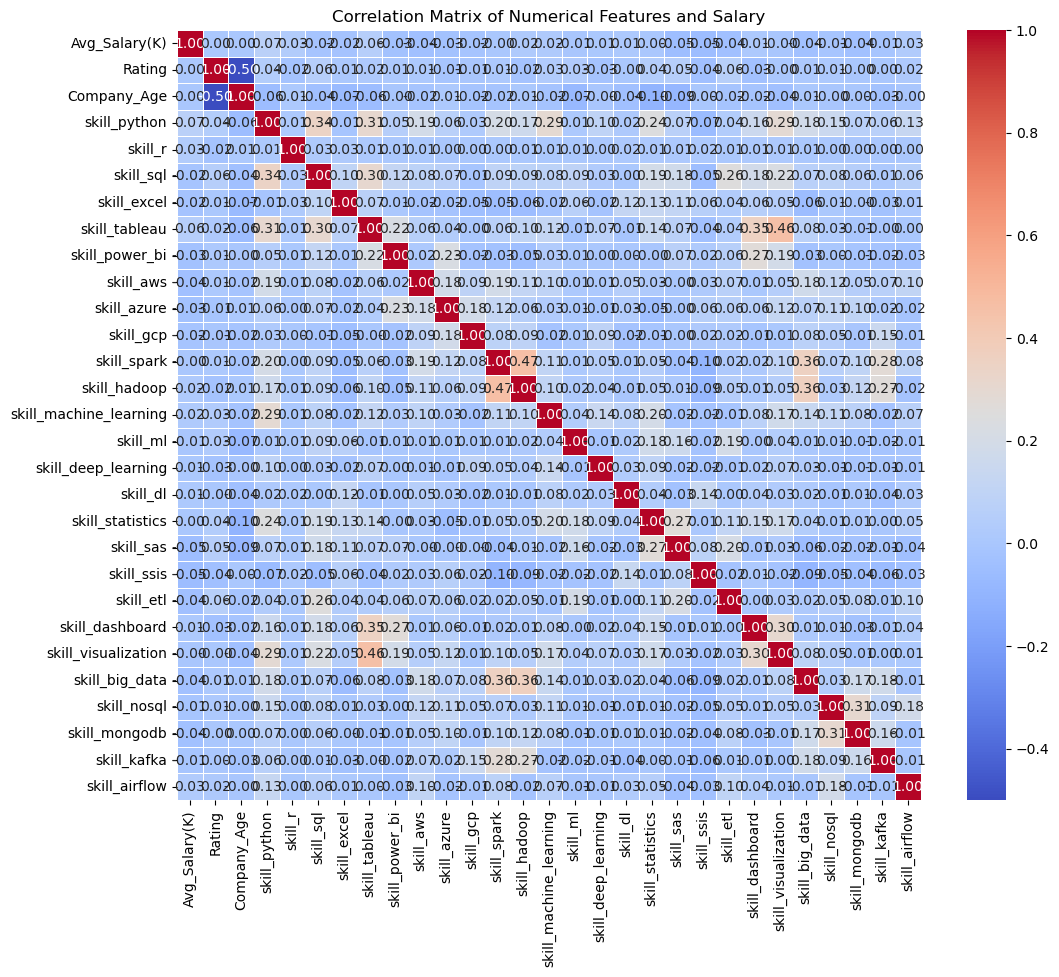


Correlation of 'Salary_Average' with other numerical features:
Avg_Salary(K)             1.000000
skill_python              0.069494
skill_tableau             0.055393
skill_r                   0.034501
skill_airflow             0.028592
skill_machine_learning    0.023169
skill_hadoop              0.022537
skill_dashboard           0.014631
skill_dl                  0.014601
skill_deep_learning       0.005438
Rating                    0.004301
Company_Age               0.001574
skill_statistics          0.000380
skill_spark              -0.000430
skill_visualization      -0.003383
skill_ml                 -0.005222
skill_nosql              -0.009443
skill_kafka              -0.011420
skill_sql                -0.017540
skill_gcp                -0.018721
skill_excel              -0.023726
skill_azure              -0.027790
skill_power_bi           -0.028462
skill_big_data           -0.035052
skill_mongodb            -0.036600
skill_etl                -0.039405
skill_aws                -

In [54]:
# ---  Statistics ---
print("\n---  Statistics - Analyze relationships using correlation and significance tests ---")

# Correlation Matrix for numerical features and Salary_Average
numerical_features_for_corr = ['Avg_Salary(K)', 'Rating', 'Company_Age'] + [col for col in data1_encoded.columns if 'skill_' in col] # Include skills
correlation_matrix = data1_encoded[numerical_features_for_corr].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features and Salary')
plt.show()

print("\nCorrelation of 'Salary_Average' with other numerical features:")
print(correlation_matrix['Avg_Salary(K)'].sort_values(ascending=False))

# Example: Significance test (ANOVA for Industry and Salary)
# ANOVA can tell us if there's a statistically significant difference between the means of salary across different industries.
from scipy.stats import f_oneway

# Filter to top industries for clarity, and ensure enough data points per group
industries_for_anova = data1_scaled['Industry_Cleaned'].value_counts()
industries_for_anova = industries_for_anova[industries_for_anova > 30].index # Only industries with > 30 data points

industry_groups = [data1_scaled['Avg_Salary(K)'][data1_scaled['Industry_Cleaned'] == ind].dropna() for ind in industries_for_anova]

if len(industry_groups) > 1:
    f_statistic, p_value = f_oneway(*industry_groups)
    print(f"\nANOVA for Salary_Average across top industries:")
    print(f"F-statistic: {f_statistic:.2f}")
    print(f"P-value: {p_value:.3f}")
    if p_value < 0.05:
        print("There is a statistically significant difference in average salaries across different industries.")
    else:
        print("There is no statistically significant difference in average salaries across different industries.")
else:
    print("\nNot enough distinct industry groups with sufficient data for ANOVA.")



In [65]:
# --- FIX FOR 'ValueError: could not convert string to float: 'True'' ---
# This ensures all boolean columns (created by get_dummies) are explicitly converted to int (0/1)
# and attempts to convert any remaining 'object' columns to numeric, filling NaNs.
print("\n--- Fixing potential non-numeric columns for model training ---")
for col in data1_encoded.columns:
    if data1_encoded[col].dtype == 'bool':
        data1_encoded[col] = data1_encoded[col].astype(int)
        print(f"Converted boolean column '{col}' to integer type.")
    elif data1_encoded[col].dtype == 'object':
        # Attempt to convert object columns to numeric, coercing errors
        original_dtype = data1_encoded[col].dtype
        data1_encoded[col] = pd.to_numeric(data1_encoded[col], errors='coerce')
        if data1_encoded[col].isnull().any():
            # If conversion created NaNs (meaning non-numeric strings were present), fill them
            data1_encoded[col].fillna(0, inplace=True) # Filling with 0 as a default for missing converted values
            print(f"Warning: Column '{col}' was object type and converted to numeric. Filled NaNs with 0.")
        # else:
            # print(f"Object column '{col}' was already numeric-like and converted to numeric.")

# Verify dtypes after conversion (optional, but good for debugging)
print("\nData types after final numeric conversion attempt (should ideally not have 'object'):")
print(data1_encoded.dtypes.value_counts())
if (data1_encoded.dtypes == 'object').any():
    print("\nWARNING: There are still 'object' type columns in df_encoded. Check these columns:")
    print(data1_encoded.select_dtypes(include='object').columns)



--- Fixing potential non-numeric columns for model training ---

Data types after final numeric conversion attempt (should ideally not have 'object'):
int64      116
float64     17
Name: count, dtype: int64


In [ ]:
# ---  Make a ML Prediction model to predict salaries and save the model ---
print("\n---  Making an ML Prediction model to predict salaries and saving the model ---")

# Defining features (X) and target (y)
# Droping original columns, keep engineered/encoded ones
# Droping 'Job Description', 'Salary Estimate', 'Job Title', 'Company Name', 'Location', 'Headquarters', 'Industry', 'Sector', 'State', 'Competitors'
# Keeping 'Rating_scaled', 'Founded_scaled', 'Company_Age', skill features, and one-hot encoded features

columns_to_drop_for_model = [
    'Job Description', 'Salary Estimate', 'Job Title', 'Company Name',
    'Location', 'Headquarters', 'Industry', 'Sector', 'State', 'Competitors',
    'Rating', 'Founded' # Drop original numerical columns after scaling
]

# Ensuring we don't drop columns that don't exist
columns_to_drop_for_model = [col for col in columns_to_drop_for_model if col in data1_encoded.columns]

X = data1_encoded.drop(columns=columns_to_drop_for_model + ['Avg_Salary(K)'])
y = data1_encoded['Avg_Salary(K)']

# Aligning columns after one-hot encoding if needed (especially for deployment)
# This step is more critical when loading new data for prediction, but good practice to be aware.
# For now, X has all the necessary encoded columns.

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")



---  Making an ML Prediction model to predict salaries and saving the model ---

Features (X) shape: (2252, 120)
Target (y) shape: (2252,)


In [67]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 1801 samples
Testing set size: 451 samples


In [68]:
# Using RandomForestRegressor Model  
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores
print("\nTraining RandomForestRegressor model...")
model.fit(X_train, y_train) # This line should now run without the ValueError
print("Model training complete.")




Training RandomForestRegressor model...
Model training complete.


In [69]:
# Evaluating the model
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Mean Squared Error (MSE): ${mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"R-squared (R2): {r2:.4f}")



Model Evaluation Metrics:
Mean Absolute Error (MAE): $0.01
Mean Squared Error (MSE): $0.00
Root Mean Squared Error (RMSE): $0.07
R-squared (R2): 1.0000


In [70]:
# Saving the trained model and feature columns for Streamlit app

model_filename = 'salary_prediction_model.pkl'
features_filename = 'model_features.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(model, file)
print(f"\nModel saved as '{model_filename}'")

with open(features_filename, 'wb') as file:
    pickle.dump(X.columns.tolist(), file)
print(f"Feature columns saved as '{features_filename}'")

print("\n--- ML Model Development Complete. Proceed to Streamlit Web App ---")



Model saved as 'salary_prediction_model.pkl'
Feature columns saved as 'model_features.pkl'

--- ML Model Development Complete. Proceed to Streamlit Web App ---
